## Part 1

Dataset used: Telco Customer Churn

https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

In [29]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az


In [30]:
telco_data = pd.read_csv('Telco.csv')
telco_data = telco_data.sample(n=3000, random_state=42)
telco_data['Churn'] = telco_data['Churn'].map({'Yes': 1, 'No': 0})
telco_data['TotalCharges'] = pd.to_numeric(telco_data['TotalCharges'], errors='coerce')
median_totalcharges = telco_data['TotalCharges'].median()
telco_data['TotalCharges'].fillna(median_totalcharges, inplace=True)
telco_encoded = pd.get_dummies(telco_data, columns=[col for col in telco_data.columns if col not in ['Churn', 'TotalCharges']], drop_first=True)

X = telco_encoded.drop('Churn', axis=1)
y = telco_encoded['Churn']
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (4302) in plot_posterior, generating only 40 plots
  warnings.warn(


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept   -1.20  1.10   -3.97    -0.06       0.47     0.35       7.0   
betas[0]     0.27  0.27   -0.00     0.54       0.19     0.16       3.0   
betas[1]    -0.28  1.36   -3.02     2.93       0.03     0.29    2042.0   
betas[2]     0.06  1.48   -3.22     2.92       0.04     0.29    1806.0   
betas[3]     0.31  1.51   -3.21     2.83       0.26     0.28     133.0   
...           ...   ...     ...      ...        ...      ...       ...   
betas[4296] -0.18  1.44   -3.68     2.50       0.04     0.31    1523.0   
betas[4297] -0.47  1.38   -2.98     2.63       0.12     0.24    1133.0   
betas[4298]  0.48  1.55   -3.32     3.12       0.26     0.29     189.0   
betas[4299] -0.41  1.51   -3.74     2.59       0.14     0.25     229.0   
betas[4300]  0.13  1.46   -3.26     2.90       0.05     0.34    1514.0   

             ess_tail  r_hat  
Intercept       332.0   2.24  
betas[0]         97.0   2.24  
betas[1]        19

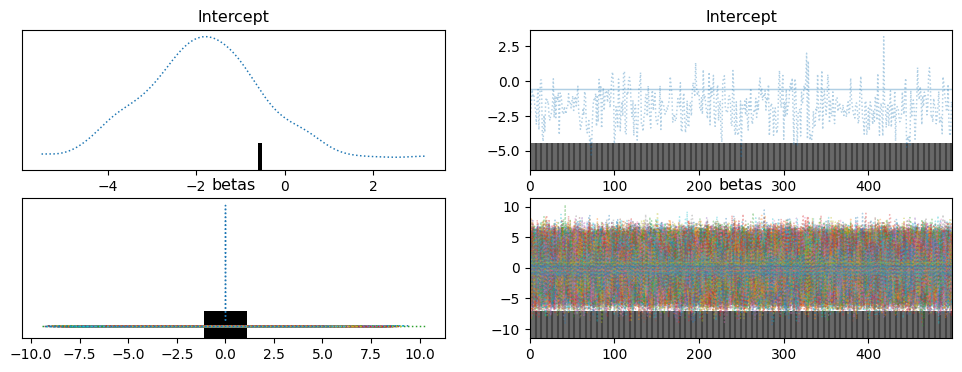

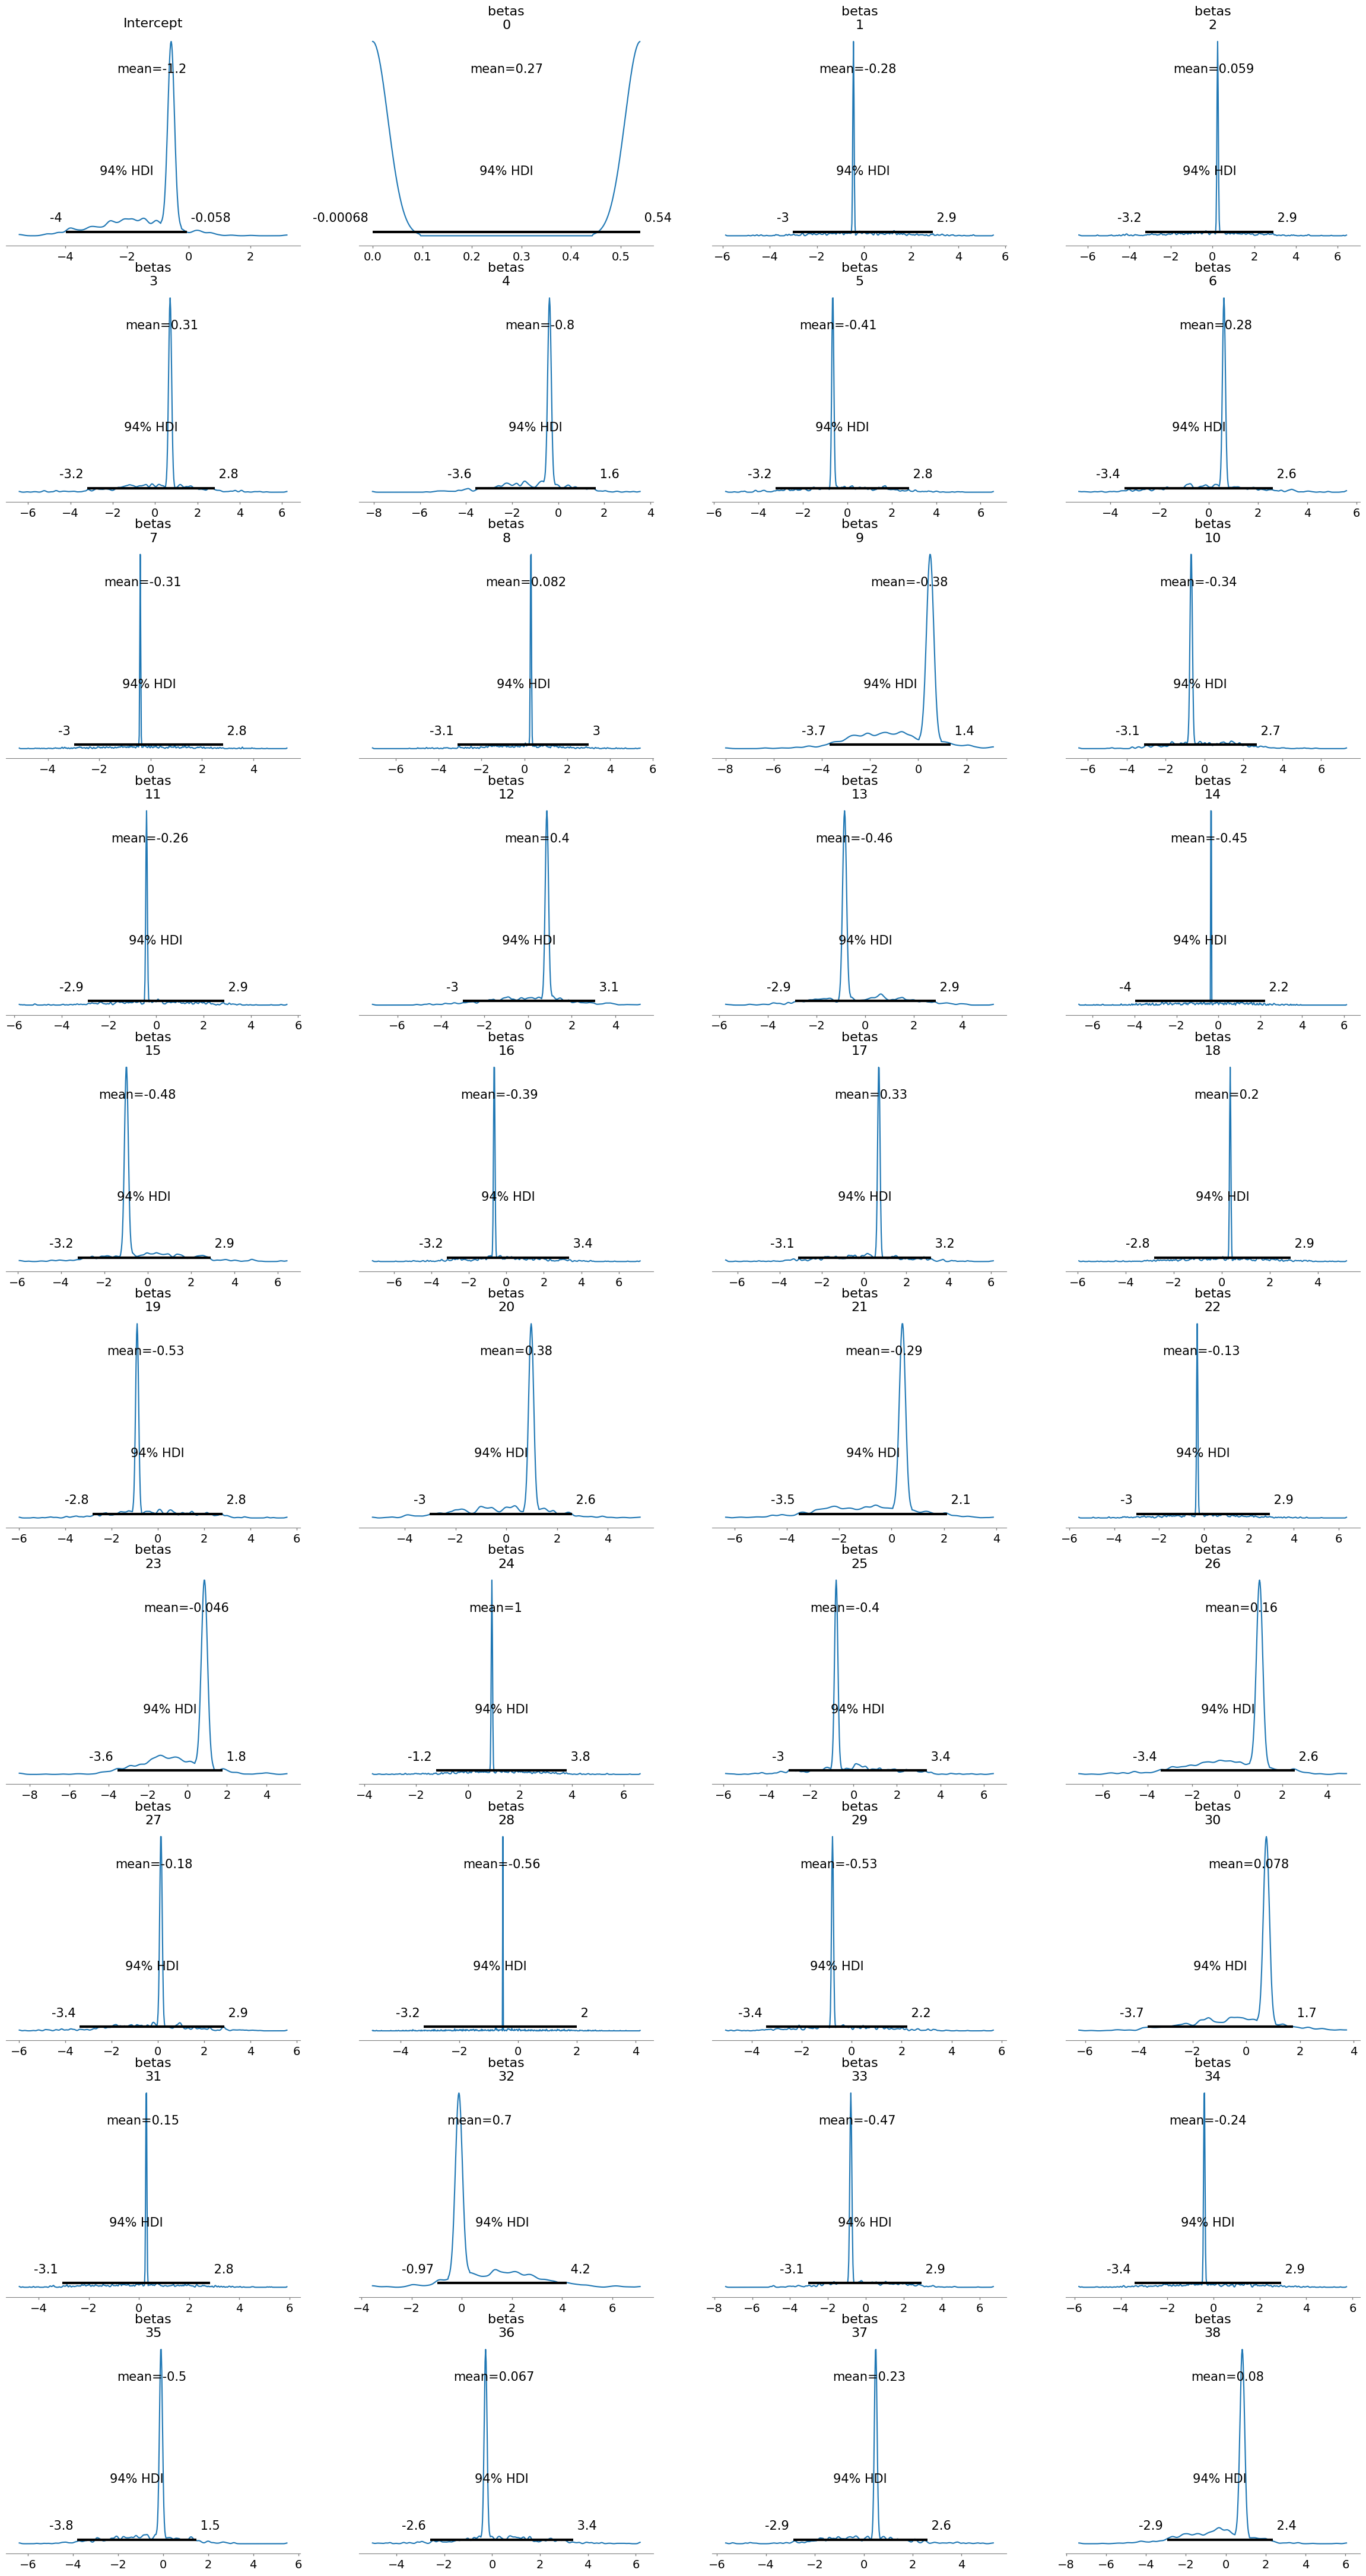

In [32]:
with pm.Model() as logistic_model:
    intercept = pm.Normal('Intercept', 0, sigma=2)
    betas = pm.Normal('betas', 0, sigma=2, shape=X_train.shape[1])

    logits = intercept + pm.math.dot(X_train, betas)

    p = pm.math.sigmoid(logits)

    likelihood = pm.Bernoulli('likelihood', p, observed=y_train)

    trace = pm.sample(500, tune=250)


with logistic_model:
    az.plot_trace(trace)
    az.plot_posterior(trace)
    summary = az.summary(trace).round(2)

print(summary)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarnin

             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept   -0.44  0.50   -0.94     0.07       0.35     0.30       2.0   
betas[0]     0.35  0.09    0.26     0.44       0.06     0.05       2.0   
betas[1]     0.32  0.47   -0.15     0.80       0.33     0.28       2.0   
betas[2]    -0.50  0.12   -0.61    -0.38       0.08     0.07       2.0   
betas[3]    -0.52  0.02   -0.55    -0.50       0.02     0.01       2.0   
...           ...   ...     ...      ...        ...      ...       ...   
betas[4296] -0.11  0.14   -0.25     0.03       0.10     0.08       2.0   
betas[4297] -0.37  0.24   -0.60    -0.13       0.16     0.14       2.0   
betas[4298]  0.17  0.61   -0.44     0.78       0.43     0.36       2.0   
betas[4299] -0.08  0.24   -0.32     0.16       0.17     0.14       2.0   
betas[4300]  0.19  0.08    0.12     0.26       0.05     0.04       2.0   

             ess_tail        r_hat  
Intercept         2.0  14462920.06  
betas[0]          2.0  14462920.06  


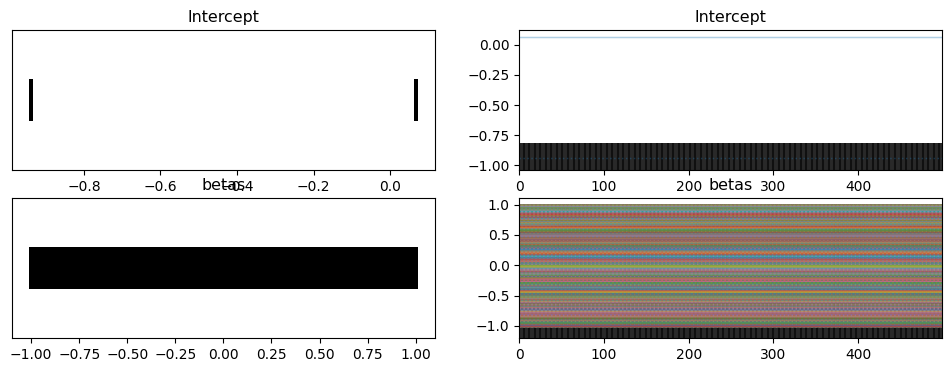

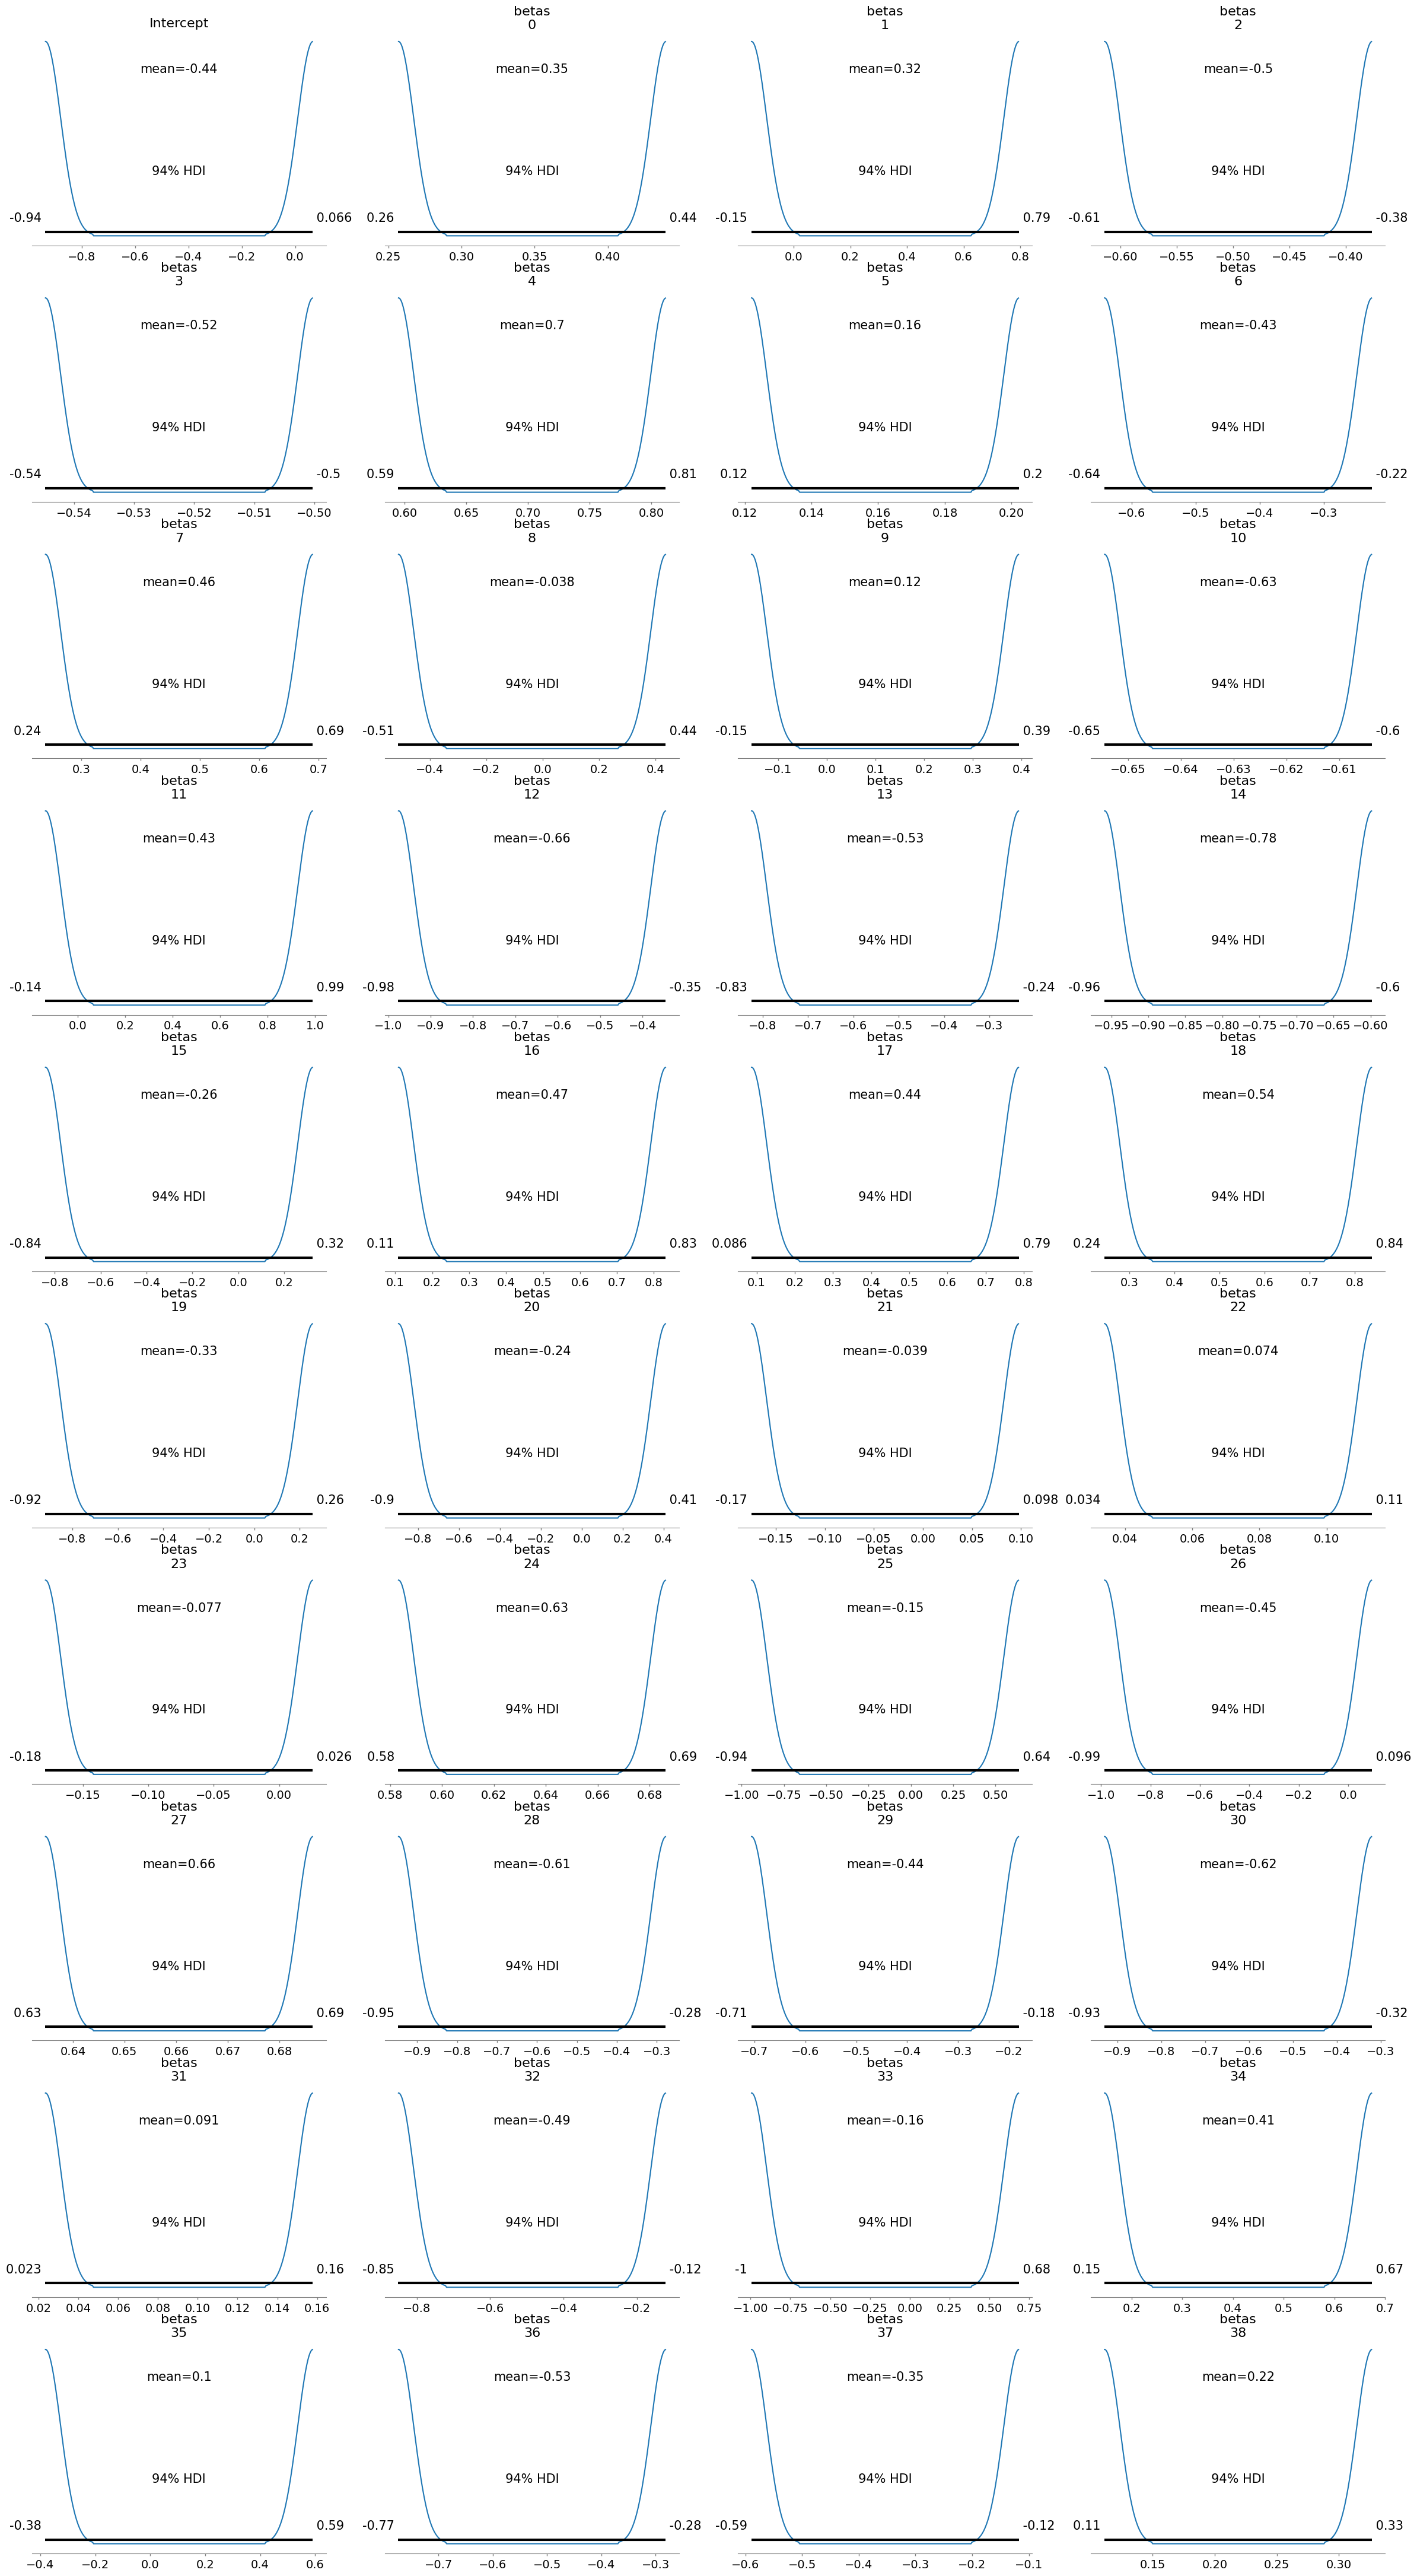

In [33]:
with pm.Model() as logistic_model:
    intercept = pm.Normal('Intercept', mu=0, sigma=2)
    betas = pm.Normal('betas', mu=0, sigma=2, shape=X_train.shape[1])

    logits = intercept + pm.math.dot(X_train, betas)

    likelihood = pm.Bernoulli('likelihood', p=pm.math.sigmoid(logits), observed=y_train)

    trace = pm.sample(500, tune=250)

with logistic_model:
    az.plot_trace(trace)
    az.plot_posterior(trace)
    summary = az.summary(trace).round(2)

print(summary)

## Part 2


The lasso regression uses an $L_1$ penalty function and its loss function can be represented as:
$$
\sum_{i=1}^n \frac{1}{2}(y_i - x_i^T\beta_{p \times 1})^2 + \lambda \sum_{j=1}^n |\beta_j| = \frac{1}{2}(y - X\beta)^T(y - X\beta) + \lambda ||\beta||_1 = \frac{1}{2}||y - X\beta||_2^2 + \lambda ||\beta||_1
$$

The ridge regression uses an $L_2$ penalty function, and its loss function is:
$$
\sum_{i=1}^n \frac{1}{2}(y_i - x_i^T\beta_{p \times 1})^2 + \lambda \sum_{j=1}^n \beta_j^2 = \frac{1}{2}(y - X\beta)^T(y - X\beta) + \lambda \sum_{j=1}^n \beta_j^2 = \frac{1}{2}||y - X\beta||_2^2 + \lambda ||\beta||_2^2
$$


In a Bayesian setting, regularization is akin to using prior distributions for the coefficients. Specifically, for ridge regression, the equivalent is a normal prior, and for lasso regression, it is a Laplace prior.

### Normal Prior

For the normal prior, the log posterior distribution for $\beta$ (ignoring constants) is proportional to the likelihood times the prior:
$$
-\frac{1}{2}||y - X\beta||_2^2 - \frac{\lambda}{2}||\beta||_2^2
$$

### Laplace Prior

For the Laplace prior, the log posterior distribution for $\beta$ (again, ignoring constants) is proportional to:
$$
-\frac{1}{2}||y - X\beta||_2^2 - \lambda||\beta||_1
$$

Thus, for $\sigma=1$ and hyperparameters $b_i=0$, the log posterior distributions for $\beta$ using normal (ridge regression) or Laplace (lasso regression) priors have forms analogous to the regularized loss functions used in machine learning.


##Part 3

In [ ]:
nu = 5
w = 1

with pm.Model() as robust_model:
    betas = pm.Normal('betas', mu=0, sigma=10, shape=X_train.shape[1])
    lambdas = pm.Gamma('lambdas', alpha=nu/2, beta=nu/2, shape=y_train.shape[0])

    y_obs = pm.Normal('y_obs', mu=pm.math.dot(X_train, betas), sigma=w * pm.math.sqrt(lambdas), observed=y_train)

    trace = pm.sample(300, tune=150)

posterior_lambdas = trace['lambdas']
